## 2. Imbalance task – 1 A4 – Martijn van Meerten 4387902

In [73]:
# If this cell does not work try running `pip install nbformat`

import io
from IPython import nbformat

nb = nbformat.read("Lab1-Task2.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

Word count: 310


## Readme - Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

In [21]:
#Insert the full path to the credit card fraud data here
data_path = "C:\\Users\Martijn.vanMeerten\workspace\studie\CDA\Lab1\data_for_student_case.csv"

In [72]:
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# install numpy, pandas, matplotlib and sklearn

### Data preprocessing

In [62]:
df1 = pd.read_csv("C:\\Users\Martijn.vanMeerten\workspace\studie\CDA\Lab1\data_for_student_case.csv")

# 1.Class label 
df1 = df1.loc[~(df1['simple_journal'] == 'Refused')]
df1.loc[df1['simple_journal'] == 'Chargeback', 'simple_journal'] = 1 #fraud
df1.loc[df1['simple_journal'] == 'Settled', 'simple_journal'] = 0

# 2.Card ID
card_enc = LabelEncoder()
card_enc.fit(df1['card_id'])
df1['card_id'] = card_enc.transform(df1.card_id)

# 3.IP ID
ip_enc = LabelEncoder()
ip_enc.fit(df1['ip_id'])
df1['ip_id'] = ip_enc.transform(df1.ip_id)

# 4. Date
df1['creationdate'] = pd.to_datetime(df1['creationdate'])
df1['date'] = df1['creationdate'].dt.date

#Encoding, Cleaning the data
df1.loc[df1['cardverificationcodesupplied'].isna(),'cardverificationcodesupplied'] = False
df1.loc[df1['issuercountrycode'].isna(),'issuercountrycode'] = 'ZZ'
df1.loc[df1['shoppercountrycode'].isna(),'shoppercountrycode'] = 'ZZ'

unique_issuer_cc = df1['issuercountrycode'].unique()
unique_shopper_cc = df1['shoppercountrycode'].unique()
both = np.append(unique_issuer_cc, unique_shopper_cc)
df_countrycodes = pd.DataFrame(both)
unique_codes = df_countrycodes[0].unique()
enc = LabelEncoder()
enc.fit(unique_codes)
df1['issuercountrycode'] = enc.transform(df1.issuercountrycode)
df1['shoppercountrycode'] = enc.transform(df1.shoppercountrycode)
def conv(row):
    currency_dict = {"BGN": 1.9558, "NZD": 1.6805, "ILS": 4.0448, "RUB": 72.2099, "CAD": 1.5075, "USD": 1.1218,
                     "PHP": 58.125, "CHF": 1.1437, "ZAR": 16.0224, "AUD": 1.5911, "JPY": 124.93, "TRY": 6.6913,
                     "HKD": 8.8007, "MYR": 4.6314, "THB": 35.802, "HRK": 7.413, "NOK": 9.6678, "IDR": 15953.68,
                     "DKK": 7.4646, "CZK": 25.659, "HUF": 322.97, "GBP": 0.86248, "MXN": 21.2829, "KRW": 1308.01,
                     "ISK": 136.2, "SGD": 1.5263, "BRL": 4.405, "PLN": 4.2868, "INR": 78.0615, "RON": 4.7596,
                     "CNY": 7.5541, "SEK": 10.635}
    return row['amount'] / (currency_dict[row['currencycode']]*100)

df1['amount_eur'] = df1.apply(lambda x: conv(x), axis=1)

# Various encodings
enc1 = LabelEncoder()
enc1.fit(df1['txvariantcode'])
df1['txvariantcode'] = enc1.transform(df1.txvariantcode)

enc2 = LabelEncoder()
enc2.fit(df1['currencycode'])
df1['currencycode'] = enc2.transform(df1.currencycode)

enc3 = LabelEncoder()
enc3.fit(df1['shopperinteraction'])
df1['shopperinteraction'] = enc3.transform(df1.shopperinteraction)

df1['accountcode'] = df1['accountcode'].apply(lambda x: re.sub('Account','',x))
df1['accountcode_cc'] = 0
df1.loc[(df1['accountcode'] == 'UK'),'accountcode_cc'] = 'GB'
df1.loc[(df1['accountcode'] == 'Mexico'),'accountcode_cc'] = 'MX'
df1.loc[(df1['accountcode'] == 'Sweden'),'accountcode_cc'] = 'SE'
df1.loc[(df1['accountcode'] == 'APAC'),'accountcode_cc'] = 'APAC'

enc4 = LabelEncoder()
enc4.fit(df1['accountcode'])
df1['accountcode'] = enc4.transform(df1.accountcode)

enccc = LabelEncoder()
enccc.fit(df1['accountcode_cc'])
df1['accountcode_cc'] = enccc.transform(df1.accountcode_cc)

enc5 = LabelEncoder()
enc5.fit(df1['cardverificationcodesupplied'])
df1['cardverificationcodesupplied'] = enc5.transform(df1.cardverificationcodesupplied)

df1.loc[df1['mail_id'].str.contains('na',case=False),'mail_id'] = 'email99999'

enc6 = LabelEncoder()
enc6.fit(df1['mail_id'])
df1['mail_id'] = enc6.transform(df1.mail_id)

df1['bookingdate'] = pd.to_datetime(df1['bookingdate'])

df1.loc[df1['cvcresponsecode'] > 2,'cvcresponsecode'] = 3

#Feature Engineering
df1['countries_equal'] = (df1['shoppercountrycode'] == df1['issuercountrycode'])
df1.loc[df1['countries_equal'] == False,'countries_equal'] = 0
df1.loc[df1['countries_equal'] == True,'countries_equal'] = 1

df1['day_of_week'] = df1['creationdate'].dt.dayofweek

df1['hour'] = df1['creationdate'].dt.hour

# Keep these columns
keep_cols = [
    "issuercountrycode",
    "txvariantcode",
    "bin",
    "amount",
    "currencycode",
    "shoppercountrycode",
    "shopperinteraction",
    "cardverificationcodesupplied",
    "cvcresponsecode",
    "accountcode",
    "mail_id",
    "ip_id",
    "card_id",
    "accountcode_cc",
    "simple_journal",
    "day_of_week",
    "hour"
]

df1 = df1[keep_cols]

# Transform to numpy arrays
y = df1["simple_journal"].to_numpy().astype(int)
df1.drop(columns="simple_journal", inplace=True)

X = df1.to_numpy().astype(float)


## SMOTE

In [63]:
# Smote implementation
# Always smotes to near equal class distribution
def smote(x_train, y_train, k):
    minority_samples = x_train[y_train.astype(bool)]
    # Find the nearest neighbors
    nbrs = NearestNeighbors(n_neighbors = k, algorithm='auto').fit(minority_samples)
    distances, indices = nbrs.kneighbors()
    number_of_minority_samples = len(minority_samples)
    number_of_majority_samples = len(x_train) - number_of_minority_samples

    # determine the ratio to smote
    amount_of_smote = int((number_of_majority_samples / number_of_minority_samples) - 1)
    numattrs = np.shape(minority_samples)[1]
    synthetic = []
    
    # Populate synthetic with the smoted samples
    def populate(amount_smote, i, nnarray):
        nonlocal synthetic
        # create 'amount_smote' number of new samples
        for _ in range(amount_smote):
            nn = int(random.random() * k) # Choose a random neighbor
            new_sample = [0]*numattrs
            # For each attribute select a value between the two minority_samples
            for attr in range(numattrs):
                dif = minority_samples[nnarray[nn]][attr] - minority_samples[i][attr]
                gap = random.random()
                new_sample[attr] = minority_samples[i][attr] + gap * dif
                
            synthetic.append(new_sample)
    
    # Smote every minority sample
    for i in range(number_of_minority_samples):
        populate(amount_of_smote, i, indices[i])
    
    return np.append(x_train, np.array(synthetic), axis=0), np.append(y_train, np.ones(shape=[1, len(synthetic)]))

### 2a. Print ROC curves

### Train classifiers

#### Random forest

In [65]:
k=5
n_folds = 5
k_fold = StratifiedKFold(n_splits=n_folds)
y_random_forest_predictions = np.zeros(len(y))
y_random_forest_index_arrays = []
# For every fold train the model and store the results
for train_index, test_index in k_fold.split(X, y):
    print("New fold")
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Smote the training data to roughly equal distribution
    X_train, y_train = smote(X_train, y_train, k)

    classifier = RandomForestClassifier(random_state=1)
    classifier.fit(X_train, y_train)

    y_pred_proba = classifier.predict_proba(X_test)[:, 1]
    y_random_forest_predictions[test_index] = y_pred_proba
    y_random_forest_index_arrays.append(test_index)


New fold
New fold
New fold
New fold
New fold


#### Naive Bayes

In [69]:
k=5
n_folds = 5
k_fold = StratifiedKFold(n_splits=n_folds)
y_naive_bayes_predictions = np.zeros(len(y))
y_naive_bayes_index_arrays = []
# For every fold train the model and store the results
for train_index, test_index in k_fold.split(X, y):
    print("new fold")
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Smote the training data to roughly equal distribution
    X_train, y_train = smote(X_train, y_train, k)

    classifier = GaussianNB()
    classifier.fit(X_train, y_train)

    y_pred_proba = classifier.predict_proba(X_test)[:, 1]
    y_naive_bayes_predictions[test_index] = y_pred_proba
    y_naive_bayes_index_arrays.append(test_index)

new fold
new fold
new fold
new fold
new fold


#### KNeighbors

In [71]:
k=5
n_folds = 5
k_fold = StratifiedKFold(n_splits=n_folds)
y_k_neighbors_predictions = np.zeros(len(y))
y_k_neighbors_index_arrays = []
# For every fold train the model and store the results
for train_index, test_index in k_fold.split(X, y):
    print("New fold")
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Smote the training data to roughly equal distribution
    X_train, y_train = smote(X_train, y_train, k)

    classifier = KNeighborsClassifier()
    classifier.fit(X_train, y_train)

    y_pred_proba = classifier.predict_proba(X_test)[:, 1]
    y_k_neighbors_predictions[test_index] = y_pred_proba
    y_k_neighbors_index_arrays.append(test_index)

New fold
New fold
New fold
New fold
New fold


#### Plot ROC curves

In [74]:
# Plot the ROC curves of all folds and their vertically averaged curve and std
def plot_roc(y_predictions, y_index_arrays, title):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    # Go through all folds
    for test_index in y_index_arrays:
        y_pred = y_predictions[test_index]
        y_test = y[test_index]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        plt.plot(fpr, tpr, alpha=.2)
        roc_auc = auc(fpr, tpr)
        # Interpolate false positives
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)

    # Calculate mean
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc))

    # Calculate standard deviation
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, alpha=.2)

    plt.legend(loc="lower right")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.plot([0, 1], [0, 1], c="gray", linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.title(title)
    plt.show()

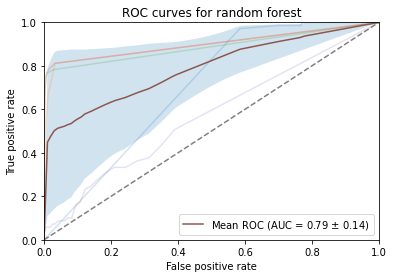

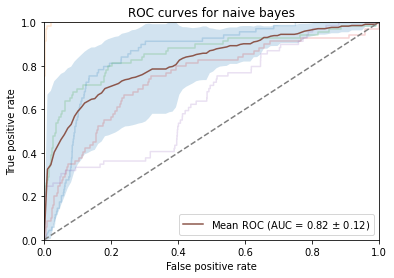

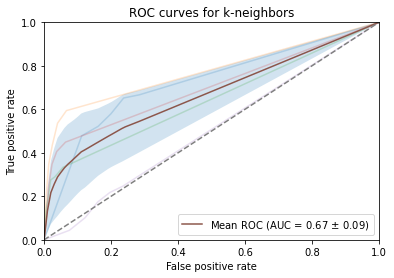

In [75]:
plot_roc(y_random_forest_predictions, y_random_forest_index_arrays, "ROC curves for random forest")
plot_roc(y_naive_bayes_predictions, y_naive_bayes_index_arrays, "ROC curves for naive bayes")
plot_roc(y_k_neighbors_predictions, y_k_neighbors_index_arrays, "ROC curves for k-neighbors")

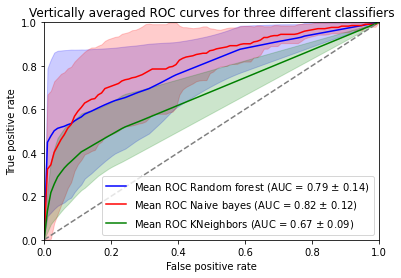

In [77]:
k = 5
n_folds = 5
y_predictions = [y_random_forest_predictions, y_naive_bayes_predictions, y_k_neighbors_predictions]
y_index_arrays = [y_random_forest_index_arrays, y_naive_bayes_index_arrays, y_k_neighbors_index_arrays]
colors = ['blue', 'red', 'green']
classifier_names = ['Random forest', 'Naive bayes', 'KNeighbors']

for i in range(3):
    k_fold = StratifiedKFold(n_splits=n_folds)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for test_index in y_index_arrays[i]:
        y_pred = y_predictions[i][test_index]
        y_test = y[test_index]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, label=r'Mean ROC %s (AUC = %0.2f $\pm$ %0.2f)' % (classifier_names[i], mean_auc, std_auc), color=colors[i])

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color=colors[i], alpha=.2)

plt.legend(loc="lower right")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title("Vertically averaged ROC curves for three different classifiers")
plt.plot([0, 1], [0, 1], c="gray", linestyle="--")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

### 2b. Analyse the performance of the classifiers. Explain which method performs best.

The five resulting ROC curves are vertically averaged to produce a single line with standard deviation in order to better compare the different classifiers. The resulting roc curves, however, contain large uncertainties and are therefore insufficient for determining the best classifier. Given the problem domain, we should primarily look at the low FPR region of the ROC curve. There is some evidence to conclude that random forest is better in that area and it is reasonably likely that the the KNeighbors classifier is outperformed by the other two. Due to the aforementioned reason, however, this is not guaranteed.

### 2c. Is using SMOTE a good idea? Why (not)?

It depends on the classifier. Using SMOTE is a good idea if the classifier suffers from class imbalance. For the random forest and k-neighbors, class imbalance has a negative influence on the performance of the classifier. Below we compare the ROC curves of the classifiers with SMOTEd data and without. It clearly shows that the resulting roc curve and auc of k-neighbors is better. Random forest appears to benefit from SMOTEing as well, but the variance increases as well. Using SMOTE for naive bayes is not beneficial. Naive bayes is a generative model. It models the joint probability distribution of the features and the target instead of the probability distribution of the target given the features. Generating new samples skews the probability distribution and worsens the performance slighty.

Text(0.5, 0.98, 'Vertically averaged ROC curves SMOTE vs no SMOTE')

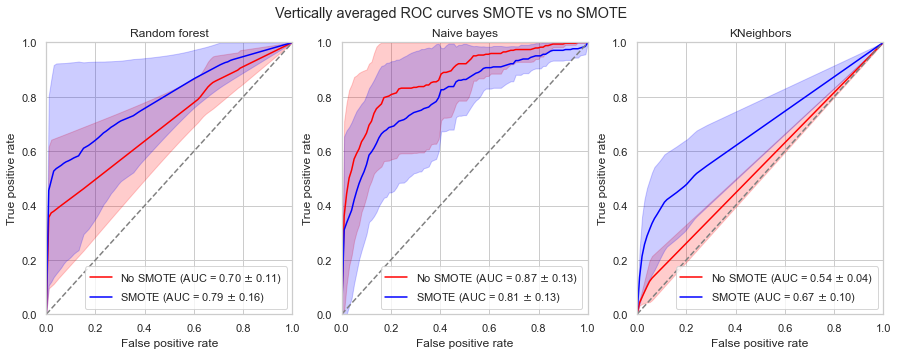

In [22]:
k = 5
n_folds = 5
classifiers = [RandomForestClassifier(random_state=1), GaussianNB(), KNeighborsClassifier()]
SMOTE = ['No SMOTE', 'SMOTE']
colors = ['red', 'blue']
classifier_names = ['Random forest', 'Naive bayes', 'KNeighbors']

fig, axs = plt.subplots(1, 3, figsize=(17,5))
for i in range(3):
    for j in range(2):
        k_fold = StratifiedKFold(n_splits=n_folds)

        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)

        for train_index, test_index in k_fold.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            if j==1:
                X_train, y_train = smote(X_train, y_train, k)

            classifiers[i].fit(X_train, y_train)

            y_pred_proba = classifiers[i].predict_proba(X_test)[:, 1]
            fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
            roc_auc = auc(fpr, tpr)
            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(roc_auc)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        axs[i].plot(mean_fpr, mean_tpr, label=r'%s (AUC = %0.2f $\pm$ %0.2f)' % (SMOTE[j], mean_auc, std_auc), color=colors[j])

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        axs[i].fill_between(mean_fpr, tprs_lower, tprs_upper, color=colors[j], alpha=.2)

    axs[i].legend(loc="lower right")
    axs[i].set(xlim=[0, 1], ylim=[0, 1], title=classifier_names[i], xlabel="False positive rate", ylabel="True positive rate")
    axs[i].plot([0, 1], [0, 1], c="gray", linestyle="--")
    
fig.suptitle('Vertically averaged ROC curves SMOTE vs no SMOTE')
